# TF-IDF

In [1]:
# Change working directory to parent so we can import as we would from main.py
%cd ..

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer # type: ignore

import configuration as config
import functions.data_manipulation as data_funcs

/mnt/arkk/llm_detector/classifier


First, let's parse and collect the data from the original Hans et al. (2024) Binoculars publication. Get some metadata about text length and composition and get the data from all six datasets into one dataframe for easy handling.

In [2]:
# Dict describing datasets to load
hans_datasets = {
    'falcon7': {
        'cc_news': 'cc_news/cc_news-falcon7.jsonl',
        'cnn': 'cnn/cnn-falcon7.jsonl',
        'pubmed': 'pubmed/pubmed-falcon7.jsonl'
    },
    'llama2-13b': {
        'cc_news': 'cc_news/cc_news-llama2_13.jsonl',
        'cnn': 'cnn/cnn-llama2_13.jsonl',
        'pubmed': 'pubmed/pubmed-llama2_13.jsonl' 
    }
}

# Output dict for collected & combined datasets
hans_data = {
    'Generation model': [],
    'Data source': [],
    'Human text length (words)': [],
    'Human text': [],
    'Synthetic text': [],
    'Synthetic text length (words)': [],
    'Human text fraction': []
}

# Output dict for datasets wide metadata
hans_metadata = {
    'Generation model': [],
    'Data source': [],
    'Records': [],
    'Mean human text length (words)': [],
    'Human text length STD': [],
    'Mean synthetic text length (words)': [],
    'Synthetic text length STD': [],
    'Mean human text fraction': []
}

# Parse, collect and combine data and get metadata
metadata_df, data_df = data_funcs.parse_hans_data(
    hans_datasets = hans_datasets, 
    hans_data = hans_data, 
    hans_metadata = hans_metadata,
    binoculars_data_path = config.HANS_DATA_PATH
)

# Save as JSON for later use
output_file = f'{config.HANS_DATA_PATH}/aggregated_hans_data.jsonl'

with open(output_file, 'w') as file:
    file.write(data_df.to_json(lines=True, orient='records'))

Parsed falcon7, cc_news data: 1169 records
Parsed falcon7, cnn data: 876 records
Parsed falcon7, pubmed data: 112 records
Parsed llama2-13b, cc_news data: 4714 records
Parsed llama2-13b, cnn data: 2208 records
Parsed llama2-13b, pubmed data: 2198 records


In [3]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
stop_words = stopwords.words('english')

sw = stopwords.words('english')
lemmatizer = WordNetLemmatizer() 

def clean_text(text: str = None) -> str:
    
    # Lowercase everything
    text = text.lower()

    # Replace everything with space except (a-z, A-Z, ".", "?", "!", ",")
    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text)

    # Remove URLs 
    text = re.sub(r"http\S+", "",text)
    
    # Remove html tags
    html = re.compile(r'<.*?>') 
    text = html.sub(r'',text)
    
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'

    # Remove punctuations
    for p in punctuations:
        text = text.replace(p,'')
        
    # Remove stopwords
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    text = [lemmatizer.lemmatize(word) for word in text]
    text = " ".join(text)
    
    # Remove emojis
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    text = emoji_pattern.sub(r'', text)
    
    return text


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/siderealyear/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/siderealyear/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
# Load Hans 2024 corpus
data_df = pd.read_json(f'{config.HANS_DATA_PATH}/aggregated_hans_data.jsonl', lines=True, orient='records')
#data_df = data_df.head(1000)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11271 entries, 0 to 11270
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Generation model               11271 non-null  object 
 1   Data source                    11271 non-null  object 
 2   Human text length (words)      11271 non-null  int64  
 3   Human text                     11271 non-null  object 
 4   Synthetic text                 11271 non-null  object 
 5   Synthetic text length (words)  11271 non-null  int64  
 6   Human text fraction            11271 non-null  float64
dtypes: float64(1), int64(2), object(4)
memory usage: 616.5+ KB


In [5]:
# Get human and synthetic text and combine
human_texts = data_df['Human text']
synthetic_texts = data_df['Synthetic text']

texts = human_texts + synthetic_texts

print('\nRaw text:\n')

for text in texts[:3]:
    print(f'{text}\n')


Raw text:

H. B. Fuller Company (NYSE:FUL) VP Traci L. Jensen sold 5,397 shares of the firm’s stock in a transaction dated Monday, October 2nd. The stock was sold at an average price of $58.40, for a total transaction of $315,184.80. The transaction was disclosed in a legal filing with the Securities & Exchange Commission, which is available through this link.
Shares of H. B. Fuller Company (NYSE:FUL) opened at 56.81 on Friday. The company’s 50-day moving average is $53.88 and its 200 day moving average is $52.11. The firm has a market capitalization of $2.87 billion, a PE ratio of 25.96 and a beta of 1.72. H. B. Fuller Company has a 52-week low of $41.52 and a 52-week high of $58.74.
Get H. B. Fuller Company alerts:
H. B. Fuller (NYSE:FUL) last released its earnings results on Wednesday, September 27th. The specialty chemicals company reported $0.65 earnings per share (EPS) for the quarter, missing the Zacks’ consensus estimate of $0.67 by ($0.02). The firm had revenue of $562.87 mil

In [6]:
texts = texts.apply(lambda x: clean_text(x))

In [7]:
print('\nCleaned text:\n')

for text in texts[:3]:
    print(f'{text}\n')


Cleaned text:

h b fuller company nyse ful vp traci l jensen sold , share firm stock transaction dated monday, october nd stock sold average price , total transaction , transaction disclosed legal filing security exchange commission, available link share h b fuller company nyse ful opened friday company day moving average day moving average firm market capitalization billion, pe ratio beta h b fuller company week low week high get h b fuller company alert h b fuller nyse ful last released earnings result wednesday, september th specialty chemical company reported earnings per share eps quarter, missing zacks consensus estimate firm revenue million quarter, compared analyst expectation million h b fuller net margin return equity equity analyst expect h b fuller company post earnings per share current fiscal year company also recently announced quarterly dividend, paid thursday, november nd shareholder record thursday, october th issued dividend represents dividend annualized basis yiel

In [8]:
tfidf_vectorizer = TfidfVectorizer() 
tfidf_vectors = tfidf_vectorizer.fit_transform(texts)
features = tfidf_vectorizer.get_feature_names_out()

tfidf_df = pd.DataFrame(
    tfidf_vectors.toarray(),
    columns = features
)

tfidf_df.head()

,aa,aaa,aaaa,aaaaccagc,aaaatcgatggtaaaggttggmec,aaac,aaadr,aaag,aaagggcagggacttaatcaac,aaalac,...,zynger,zyryanovskaya,zytaruk,zyuganov,zyxuj,zz,zzph,zzplzxj,zzr,zzxlynts
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.015256,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
tfidf_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11271 entries, 0 to 11270
Columns: 173087 entries, aa to zzxlynts
dtypes: float64(173087)
memory usage: 14.5 GB


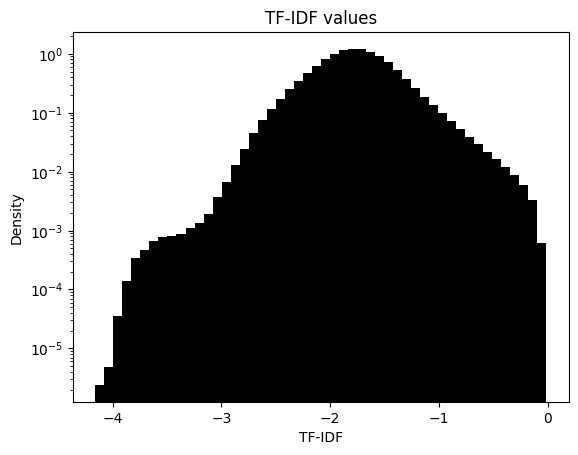

In [10]:
import numpy as np

tf_idf_values = tfidf_df.to_numpy().flatten()
tf_idf_values = tf_idf_values[tf_idf_values != 0]

plt.title('TF-IDF values')
plt.hist(np.log10(tf_idf_values), bins = 50, log = True, facecolor = 'black', density = True)
plt.xlabel('TF-IDF')
plt.ylabel('Density')
plt.show()

In [11]:
# Get corpus wide mean by word
tfidf_df_sum = tfidf_df.sum(axis = 1)
tfidf_df_mean = tfidf_df_sum / len(tfidf_df_sum)

# Make dictionary look-up table of feature names and mean TF-IDF values
tfidf_lut = dict(zip(tfidf_df.columns, tfidf_df_mean))

In [12]:
# Load the fragments
data_df = pd.read_json(config.COMBINED_SCORED_HANS_DATA_PR)
data_df = data_df.head(1000)
data_df.info()
print()
data_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Fragment length (tokens)                 1000 non-null   int64  
 1   Dataset                                  1000 non-null   object 
 2   Source                                   1000 non-null   object 
 3   String                                   1000 non-null   object 
 4   Perplexity                               1000 non-null   float64
 5   Cross-perplexity                         1000 non-null   float64
 6   Perplexity ratio score                   1000 non-null   float64
 7   Perplexity ratio Kullback-Leibler score  999 non-null    float64
dtypes: float64(4), int64(1), object(3)
memory usage: 70.3+ KB



,Fragment length (tokens),Dataset,Source,String,Perplexity,Cross-perplexity,Perplexity ratio score,Perplexity ratio Kullback-Leibler score
0,229,cc_news-falcon7,human,H. B. Fuller Company (NYSE:FUL) VP Traci L. Je...,0.971085,1.146746,0.846818,1.498175
1,267,cc_news-falcon7,human,specialty chemicals company reported $0.65 ear...,1.185710,1.238428,0.957431,0.189686
2,290,cc_news-falcon7,human,reposted in violation of US and international ...,1.212603,1.270731,0.954256,0.198995
3,156,cc_news-falcon7,human,one has issued a buy rating to the company. Th...,1.285289,1.332959,0.964237,0.174337
4,231,cc_news-falcon7,human,specialty chemicals company’s stock valued at ...,1.272878,1.475141,0.862886,1.220695


In [13]:
# Score the Hans 2024 text fragments

# Holders for TF-IDF values
human_fragment_tfidf_means = []
synthetic_fragment_tfidf_means = []

# Loop on dataframe rows
for index, row in data_df.iterrows():
    
    tfidf_sum = 0

    # Get the text from this row
    text = row['String']

    # Clean the text
    text = clean_text(text)

    # Split the text into words
    words = text.split(' ')

    # Score the words
    for word in words:
        if word in tfidf_lut.keys() and tfidf_lut[word] != 0:
            tfidf_sum += tfidf_lut[word]

    # Get the mean
    tfidf_mean = tfidf_sum / len(words)

    if row['Source'] == 'human':
        human_fragment_tfidf_means.append(tfidf_mean)

    elif row['Source'] == 'synthetic':
        synthetic_fragment_tfidf_means.append(tfidf_mean)


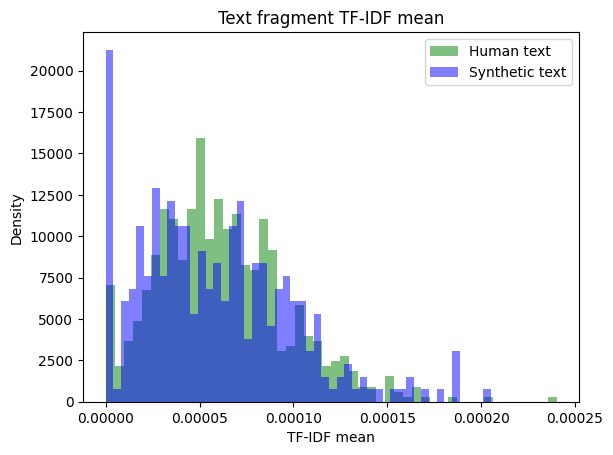

In [14]:
plt.title('Text fragment TF-IDF mean')
plt.hist(human_fragment_tfidf_means, bins = 50, facecolor = 'green', density = True, label = 'Human text', alpha = 0.5)
plt.hist(synthetic_fragment_tfidf_means, bins = 50, facecolor = 'blue', density = True, label = 'Synthetic text', alpha = 0.5)
plt.xlabel('TF-IDF mean')
plt.ylabel('Density')
plt.legend(loc = 'upper right')
plt.show()

In [15]:
# Load Hans 2024 corpus
data_df = pd.read_json(f'{config.HANS_DATA_PATH}/aggregated_hans_data.jsonl', lines=True, orient='records')
#data_df = data_df.head(1000)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11271 entries, 0 to 11270
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Generation model               11271 non-null  object 
 1   Data source                    11271 non-null  object 
 2   Human text length (words)      11271 non-null  int64  
 3   Human text                     11271 non-null  object 
 4   Synthetic text                 11271 non-null  object 
 5   Synthetic text length (words)  11271 non-null  int64  
 6   Human text fraction            11271 non-null  float64
dtypes: float64(1), int64(2), object(4)
memory usage: 616.5+ KB


In [16]:
data_df.head()

,Generation model,Data source,Human text length (words),Human text,Synthetic text,Synthetic text length (words),Human text fraction
0,falcon7,cc_news,836,H. B. Fuller Company (NYSE:FUL) VP Traci L. Je...,"$54.40, for a total value of $298,532.80. Fol...",307,0.731409
1,falcon7,cc_news,1153,"On Aug. 21, a solar eclipse will cut across th...",covers the sun.\nThe total eclipse will be vi...,382,0.751140
2,falcon7,cc_news,725,Study on Aerosol Valves Market by Infinium Glo...,of Aerosol Valves market by type (Aerosol Noz...,324,0.691134
3,falcon7,cc_news,689,"VICTORIA – More than 1,400 British Columbians ...",",423 illicit drug overdose deaths in 2017, up ...",373,0.648776
4,falcon7,cc_news,869,"On land, heatwaves can be deadly for humans an...","sometimes even larger, more mobile species of...",386,0.692430


In [17]:
# Get human and synthetic text
human_texts = data_df['Human text']
synthetic_texts = data_df['Synthetic text']

# Clean for vectorization
human_texts = human_texts.apply(lambda x: clean_text(x))
synthetic_texts = synthetic_texts.apply(lambda x: clean_text(x))

In [18]:
human_tfidf_vectorizer = TfidfVectorizer() 
human_tfidf_vectors = human_tfidf_vectorizer.fit_transform(human_texts)
human_features = human_tfidf_vectorizer.get_feature_names_out()

human_tfidf_df = pd.DataFrame(
    human_tfidf_vectors.toarray(),
    columns = human_features
).replace(0, np.NaN)

log_human_tfidf_df = np.log2(human_tfidf_df)

human_tf_idf_values = human_tfidf_df.to_numpy().flatten()
human_tf_idf_values = human_tf_idf_values[human_tf_idf_values != 0]

synthetic_tfidf_vectorizer = TfidfVectorizer() 
synthetic_tfidf_vectors = synthetic_tfidf_vectorizer.fit_transform(synthetic_texts)
synthetic_features = synthetic_tfidf_vectorizer.get_feature_names_out()

synthetic_tfidf_df = pd.DataFrame(
    synthetic_tfidf_vectors.toarray(),
    columns = synthetic_features
).replace(0, np.NaN)

log_synthetic_tfidf_df = np.log2(synthetic_tfidf_df)

synthetic_tf_idf_values = synthetic_tfidf_df.to_numpy().flatten()
synthetic_tf_idf_values = synthetic_tf_idf_values[synthetic_tf_idf_values != 0]

In [19]:
human_tfidf_df_sum = human_tfidf_df.sum(axis = 1)
synthetic_tfidf_df_sum = synthetic_tfidf_df.sum(axis = 1)

human_tfidf_df_mean = human_tfidf_df.mean()
synthetic_tfidf_df_mean = synthetic_tfidf_df.mean()

log_human_tfidf_df_mean = log_human_tfidf_df.mean()
log_synthetic_tfidf_df_mean = log_synthetic_tfidf_df.mean()

human_tfidf_mean_of_means = human_tfidf_df_mean.mean()
synthetic_tfidf_mean_of_means = synthetic_tfidf_df_mean.mean()

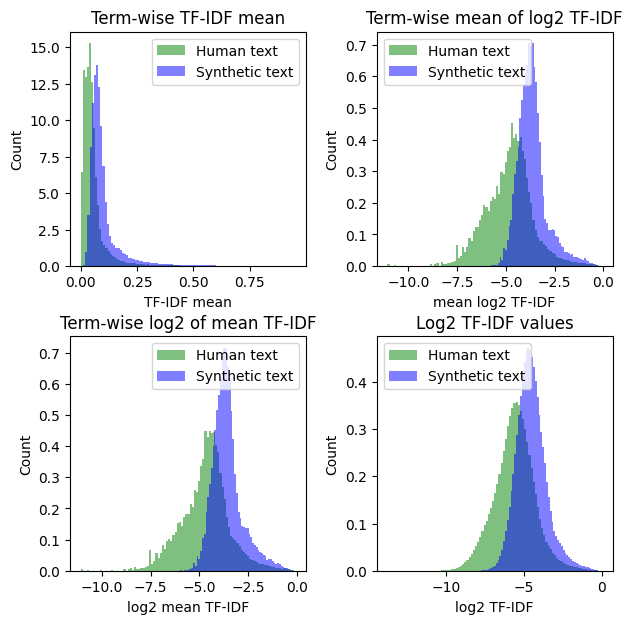

In [20]:
fig, axs = plt.subplots(
    2,
    2,
    figsize = (7, 7),
    gridspec_kw = {'wspace':0.3, 'hspace':0.3}
)

axs[0,0].set_title('Term-wise TF-IDF mean')
axs[0,0].hist(human_tfidf_df_mean, bins = 100, density = True, facecolor = 'green', label = 'Human text', alpha = 0.5)
axs[0,0].hist(synthetic_tfidf_df_mean, bins = 100, density = True, facecolor = 'blue', label = 'Synthetic text', alpha = 0.5)
axs[0,0].set_xlabel('TF-IDF mean')
axs[0,0].set_ylabel('Count')
axs[0,0].legend(loc = 'upper right')

axs[0,1].set_title('Term-wise mean of log2 TF-IDF')
axs[0,1].hist(log_human_tfidf_df_mean, bins = 100, density = True, facecolor = 'green', label = 'Human text', alpha = 0.5)
axs[0,1].hist(log_synthetic_tfidf_df_mean, bins = 100, density = True, facecolor = 'blue', label = 'Synthetic text', alpha = 0.5)
axs[0,1].set_xlabel('mean log2 TF-IDF')
axs[0,1].set_ylabel('Count')
axs[0,1].legend(loc = 'upper left')

axs[1,0].set_title('Term-wise log2 of mean TF-IDF')
axs[1,0].hist(np.log2(human_tfidf_df_mean), bins = 100, density = True, facecolor = 'green', label = 'Human text', alpha = 0.5)
axs[1,0].hist(np.log2(synthetic_tfidf_df_mean), bins = 100, density = True, facecolor = 'blue', label = 'Synthetic text', alpha = 0.5)
axs[1,0].set_xlabel('log2 mean TF-IDF')
axs[1,0].set_ylabel('Count')
axs[1,0].legend(loc = 'upper right')

axs[1,1].set_title('Log2 TF-IDF values')
axs[1,1].hist(np.log2(human_tf_idf_values), bins = 100, density = True, facecolor = 'green', label = 'Human text', alpha = 0.5)
axs[1,1].hist(np.log2(synthetic_tf_idf_values), bins = 100, density = True, facecolor = 'blue', label = 'Synthetic text', alpha = 0.5)
axs[1,1].set_xlabel('log2 TF-IDF')
axs[1,1].set_ylabel('Count')
axs[1,1].legend(loc = 'upper left')

plt.show()

Good, distributions are clearly different. Problem is, we can't calculate TF-IDF on a single user submitted text fragment. Let's try scoring text fragments using the mean log2 TF-IDF from the human and synthetic texts. Maybe human and synthetic fragments will score differently with human or synthetic TF-IDFs.

OK, so now this is like a 2 x 2 I think? We need to score human fragments as human and synthetic and synthetic fragments as human and synthetic.

In [21]:
# Make the look-up tables
tfidf_luts = {
    'human': dict(zip(human_tfidf_df.columns, log_human_tfidf_df_mean)),
    'synthetic': dict(zip(synthetic_tfidf_df.columns, log_synthetic_tfidf_df_mean))
}

In [22]:
# Load the text fragments
data_df = pd.read_json(config.COMBINED_SCORED_HANS_DATA_PR)
#data_df = data_df.head(1000)
data_df.info()
print()
data_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 119818 entries, 0 to 119817
Data columns (total 8 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   Fragment length (tokens)                 119818 non-null  int64  
 1   Dataset                                  119818 non-null  object 
 2   Source                                   119818 non-null  object 
 3   String                                   119818 non-null  object 
 4   Perplexity                               119818 non-null  float64
 5   Cross-perplexity                         119818 non-null  float64
 6   Perplexity ratio score                   119818 non-null  float64
 7   Perplexity ratio Kullback-Leibler score  119730 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 8.2+ MB



,Fragment length (tokens),Dataset,Source,String,Perplexity,Cross-perplexity,Perplexity ratio score,Perplexity ratio Kullback-Leibler score
0,229,cc_news-falcon7,human,H. B. Fuller Company (NYSE:FUL) VP Traci L. Je...,0.971085,1.146746,0.846818,1.498175
1,267,cc_news-falcon7,human,specialty chemicals company reported $0.65 ear...,1.185710,1.238428,0.957431,0.189686
2,290,cc_news-falcon7,human,reposted in violation of US and international ...,1.212603,1.270731,0.954256,0.198995
3,156,cc_news-falcon7,human,one has issued a buy rating to the company. Th...,1.285289,1.332959,0.964237,0.174337
4,231,cc_news-falcon7,human,specialty chemicals company’s stock valued at ...,1.272878,1.475141,0.862886,1.220695


In [23]:
# Score the Hans 2024 text fragments

# Holders for TF-IDF values
human_as_human_tfidf_means = []
human_as_synthetic_tfidf_means = []
synthetic_as_human_tfidf_means = []
synthetic_as_synthetic_tfidf_means = []

# Loop on dataframe rows
for index, row in data_df.iterrows():
    
    human_tfidf_sum = 0
    synthetic_tfidf_sum = 0

    # Get the text from this row
    text = row['String']

    # Clean the text
    text = clean_text(text)

    # Split the text into words
    words = text.split(' ')

    # Score the words using the human and synthetic luts
    for word in words:

        if word in tfidf_luts['human'].keys():
            human_tfidf_sum += tfidf_luts['human'][word]

        if word in tfidf_luts['synthetic'].keys():
            synthetic_tfidf_sum += tfidf_luts['synthetic'][word]

    # Get the means
    human_tfidf_mean = human_tfidf_sum / len(words)
    synthetic_tfidf_mean = synthetic_tfidf_sum / len(words)

    if row['Source'] == 'human':
        human_as_human_tfidf_means.append(human_tfidf_mean)
        human_as_synthetic_tfidf_means.append(synthetic_tfidf_mean)

    elif row['Source'] == 'synthetic':
        synthetic_as_human_tfidf_means.append(human_tfidf_mean)
        synthetic_as_synthetic_tfidf_means.append(synthetic_tfidf_mean)



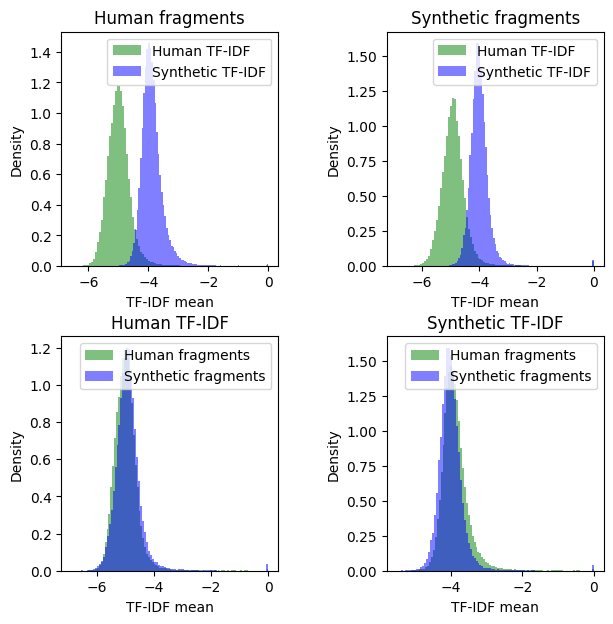

In [24]:
fig, axs = plt.subplots(
    2,
    2,
    figsize = (7, 7),
    gridspec_kw = {'wspace':0.5, 'hspace':0.3}
)

axs[0,0].set_title('Human fragments')
axs[0,0].hist(human_as_human_tfidf_means, bins = 100, density = True, facecolor = 'green', label = 'Human TF-IDF', alpha = 0.5)
axs[0,0].hist(human_as_synthetic_tfidf_means, bins = 100, density = True, facecolor = 'blue', label = 'Synthetic TF-IDF', alpha = 0.5)
axs[0,0].set_xlabel('TF-IDF mean')
axs[0,0].set_ylabel('Density')
axs[0,0].legend(loc = 'upper right')

axs[0,1].set_title('Synthetic fragments')
axs[0,1].hist(synthetic_as_human_tfidf_means, bins = 100, density = True, facecolor = 'green', label = 'Human TF-IDF', alpha = 0.5)
axs[0,1].hist(synthetic_as_synthetic_tfidf_means, bins = 100, density = True, facecolor = 'blue', label = 'Synthetic TF-IDF', alpha = 0.5)
axs[0,1].set_xlabel('TF-IDF mean')
axs[0,1].set_ylabel('Density')
axs[0,1].legend(loc = 'upper right')

axs[1,0].set_title('Human TF-IDF')
axs[1,0].hist(human_as_human_tfidf_means, bins = 100, density = True, facecolor = 'green', label = 'Human fragments', alpha = 0.5)
axs[1,0].hist(synthetic_as_human_tfidf_means, bins = 100, density = True, facecolor = 'blue', label = 'Synthetic fragments', alpha = 0.5)
axs[1,0].set_xlabel('TF-IDF mean')
axs[1,0].set_ylabel('Density')
axs[1,0].legend(loc = 'upper right')

axs[1,1].set_title('Synthetic TF-IDF')
axs[1,1].hist(human_as_synthetic_tfidf_means, bins = 100, density = True, facecolor = 'green', label = 'Human fragments', alpha = 0.5)
axs[1,1].hist(synthetic_as_synthetic_tfidf_means, bins = 100, density = True, facecolor = 'blue', label = 'Synthetic fragments', alpha = 0.5)
axs[1,1].set_xlabel('TF-IDF mean')
axs[1,1].set_ylabel('Density')
axs[1,1].legend(loc = 'upper right')

plt.show()

OK, so pretty sure we are just seeing the differences in the underlying distributions of TF-IDFs. In the top panels scoring with human values gives lower scores than with synthetic values, but that is as true for human text fragments as it is for synthetic ones. This is pretty obvious on the bottom panels where the score distributions for human and synthetic fragments are the same when scored either way.

Let's try looking at the individual values per word, rather than averaging them across the fragments.

In [25]:
# Score the Hans 2024 text fragments

# Holders for TF-IDF values
human_as_human_tfidfs = []
human_as_synthetic_tfidfs = []
synthetic_as_human_tfidfs = []
synthetic_as_synthetic_tfidfs = []

# Loop on dataframe rows
for index, row in data_df.iterrows():

    # Get the text from this row
    text = row['String']

    # Clean the text
    text = clean_text(text)

    # Split the text into words
    words = text.split(' ')

    # Score the words using the human and synthetic luts
    for word in words:

        if word in tfidf_luts['human'].keys():
            human_tfidf = tfidf_luts['human'][word]

            if row['Source'] == 'human':
                human_as_human_tfidfs.append(human_tfidf)

            elif row['Source'] == 'synthetic':
                synthetic_as_human_tfidfs.append(human_tfidf)

        if word in tfidf_luts['synthetic'].keys():
            synthetic_tfidf = tfidf_luts['synthetic'][word]

            if row['Source'] == 'human':
                human_as_synthetic_tfidfs.append(synthetic_tfidf)

            elif row['Source'] == 'synthetic':
                synthetic_as_synthetic_tfidfs.append(synthetic_tfidf)

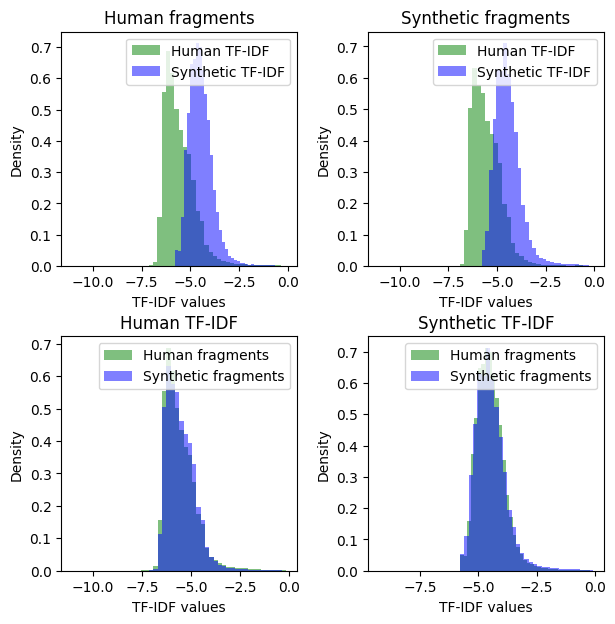

In [26]:
fig, axs = plt.subplots(
    2,
    2,
    figsize = (7, 7),
    gridspec_kw = {'wspace':0.3, 'hspace':0.3}
)

axs[0,0].set_title('Human fragments')
axs[0,0].hist(human_as_human_tfidfs, bins = 50, density = True, facecolor = 'green', label = 'Human TF-IDF', alpha = 0.5)
axs[0,0].hist(human_as_synthetic_tfidfs, bins = 50, density = True, facecolor = 'blue', label = 'Synthetic TF-IDF', alpha = 0.5)
axs[0,0].set_xlabel('TF-IDF values')
axs[0,0].set_ylabel('Density')
axs[0,0].legend(loc = 'upper right')

axs[0,1].set_title('Synthetic fragments')
axs[0,1].hist(synthetic_as_human_tfidfs, bins = 50, density = True, facecolor = 'green', label = 'Human TF-IDF', alpha = 0.5)
axs[0,1].hist(synthetic_as_synthetic_tfidfs, bins = 50, density = True, facecolor = 'blue', label = 'Synthetic TF-IDF', alpha = 0.5)
axs[0,1].set_xlabel('TF-IDF values')
axs[0,1].set_ylabel('Density')
axs[0,1].legend(loc = 'upper right')

axs[1,0].set_title('Human TF-IDF')
axs[1,0].hist(human_as_human_tfidfs, bins = 50, density = True, facecolor = 'green', label = 'Human fragments', alpha = 0.5)
axs[1,0].hist(synthetic_as_human_tfidfs, bins = 50, density = True, facecolor = 'blue', label = 'Synthetic fragments', alpha = 0.5)
axs[1,0].set_xlabel('TF-IDF values')
axs[1,0].set_ylabel('Density')
axs[1,0].legend(loc = 'upper right')

axs[1,1].set_title('Synthetic TF-IDF')
axs[1,1].hist(human_as_synthetic_tfidfs, bins = 50, density = True, facecolor = 'green', label = 'Human fragments', alpha = 0.5)
axs[1,1].hist(synthetic_as_synthetic_tfidfs, bins = 50, density = True, facecolor = 'blue', label = 'Synthetic fragments', alpha = 0.5)
axs[1,1].set_xlabel('TF-IDF values')
axs[1,1].set_ylabel('Density')
axs[1,1].legend(loc = 'upper right')

plt.show()

Yeah, not great, same deal.

So, let's try this - look at the difference between human and synthetic TF-IDF scores for human and synthetic fragments, idea being that the difference will be smaller for human fragments and larger for synthetic fragments.

In [27]:
# Score the Hans 2024 text fragments

# Holders for dTF-IDF values
human_dtfidfs = []
synthetic_dtfidfs = []
human_dtfidfs_ratio = []
synthetic_dtfidfs_ratio = []
product_normalized_human_dtfidfs = []
product_normalized_synthetic_dtfidfs = []
human_dtfidfs_product = []
synthetic_dtfidfs_product = []

# Loop on dataframe rows
for index, row in data_df.iterrows():

    # Get the text from this row
    text = row['String']

    # Clean the text
    text = clean_text(text)

    # Split the text into words
    words = text.split(' ')

    # Score the words using the human and synthetic luts
    for word in words:

        if word in tfidf_luts['human'].keys():
            human_tfidf = tfidf_luts['human'][word]

        else:
            human_tfidf = 0

        if word in tfidf_luts['synthetic'].keys():
            synthetic_tfidf = tfidf_luts['synthetic'][word]

        else:
            synthetic_tfidf = 0

        if human_tfidf + synthetic_tfidf != 0:

            if row['Source'] == 'human':
                human_dtfidfs.append(human_tfidf - synthetic_tfidf)
                product_normalized_human_dtfidfs.append((human_tfidf - synthetic_tfidf) * (human_tfidf + synthetic_tfidf))
                human_dtfidfs_product.append(human_tfidf * synthetic_tfidf)

            elif row['Source'] == 'synthetic':
                synthetic_dtfidfs.append(human_tfidf - synthetic_tfidf)
                product_normalized_synthetic_dtfidfs.append((human_tfidf - synthetic_tfidf) * (human_tfidf + synthetic_tfidf))
                synthetic_dtfidfs_product.append(human_tfidf * synthetic_tfidf)

        if synthetic_tfidf != 0:
            if row['Source'] == 'human':
                human_dtfidfs_ratio.append(human_tfidf / synthetic_tfidf)

            elif row['Source'] == 'synthetic':
                synthetic_dtfidfs_ratio.append(human_tfidf / synthetic_tfidf)

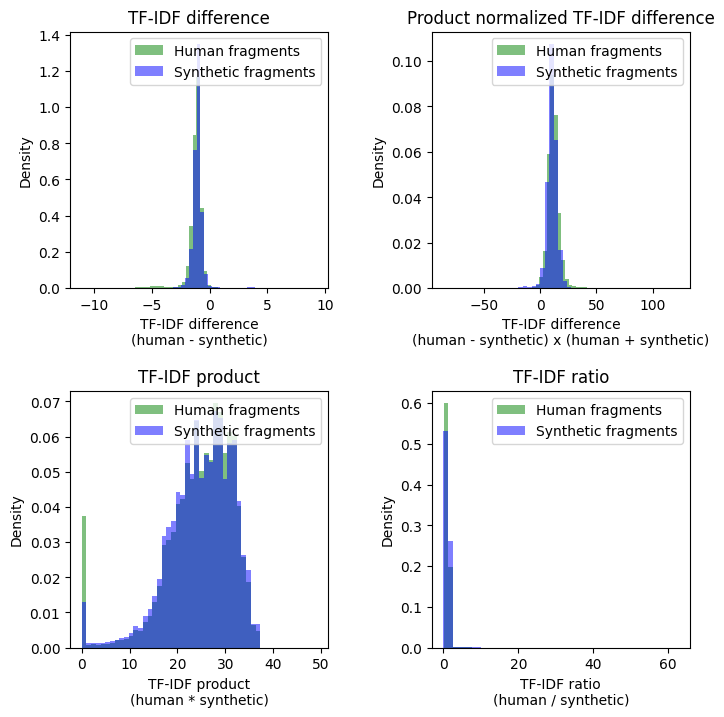

In [28]:
fig, axs = plt.subplots(
    2,
    2,
    figsize = (8, 8),
    gridspec_kw = {'wspace':0.4, 'hspace':0.4}
)

axs[0,0].set_title('TF-IDF difference')
axs[0,0].hist(human_dtfidfs, density = True, bins = 50, facecolor = 'green', label = 'Human fragments', alpha = 0.5)
axs[0,0].hist(synthetic_dtfidfs, density = True, bins = 50, facecolor = 'blue', label = 'Synthetic fragments', alpha = 0.5)
axs[0,0].set_xlabel('TF-IDF difference\n(human - synthetic)')
axs[0,0].set_ylabel('Density')
axs[0,0].legend(loc = 'upper right')

axs[0,1].set_title('Product normalized TF-IDF difference')
axs[0,1].hist(product_normalized_human_dtfidfs, density = True, bins = 50, facecolor = 'green', label = 'Human fragments', alpha = 0.5)
axs[0,1].hist(product_normalized_synthetic_dtfidfs, density = True, bins = 50, facecolor = 'blue', label = 'Synthetic fragments', alpha = 0.5)
axs[0,1].set_xlabel('TF-IDF difference\n(human - synthetic) x (human + synthetic)')
axs[0,1].set_ylabel('Density')
axs[0,1].legend(loc = 'upper right')

axs[1,0].set_title('TF-IDF product')
axs[1,0].hist(human_dtfidfs_product, density = True, bins = 50, facecolor = 'green', label = 'Human fragments', alpha = 0.5)
axs[1,0].hist(synthetic_dtfidfs_product, density = True, bins = 50, facecolor = 'blue', label = 'Synthetic fragments', alpha = 0.5)
axs[1,0].set_xlabel('TF-IDF product\n(human * synthetic)')
axs[1,0].set_ylabel('Density')
axs[1,0].legend(loc = 'upper right')

axs[1,1].set_title('TF-IDF ratio')
axs[1,1].hist(human_dtfidfs_ratio, density = True, bins = 50, facecolor = 'green', label = 'Human fragments', alpha = 0.5)
axs[1,1].hist(synthetic_dtfidfs_ratio, density = True, bins = 50, facecolor = 'blue', label = 'Synthetic fragments', alpha = 0.5)
axs[1,1].set_xlabel('TF-IDF ratio\n(human / synthetic)')
axs[1,1].set_ylabel('Density')
axs[1,1].legend(loc = 'upper right')

plt.show()

Nope, no good all look the same to me. Ok, so I think the best shot we have is to use the difference in fragment mean when scored using human and synthetic TF-IDF values. Let's set it up:


In [29]:
# Score the Hans 2024 text fragments

# Holders for TF-IDF values
human_as_human_tfidf_means = []
human_as_synthetic_tfidf_means = []
synthetic_as_human_tfidf_means = []
synthetic_as_synthetic_tfidf_means = []
human_dmean_tfidf = []
synthetic_dmean_tfidf = []
product_normalized_human_dmean_tfidf = []
product_normalized_synthetic_dmean_tfidf = []
quotient_normalized_human_dmean_tfidf = []
quotient_normalized_synthetic_dmean_tfidf = []
human_tfidf_mean_ratio = []
synthetic_tfidf_mean_ratio = []

# Loop on dataframe rows
for index, row in data_df.iterrows():
    
    human_tfidf_sum = 0
    synthetic_tfidf_sum = 0

    # Get the text from this row
    text = row['String']

    # Clean the text
    text = clean_text(text)

    # Split the text into words
    words = text.split(' ')

    # Score the words using the human and synthetic luts
    for word in words:

        if word in tfidf_luts['human'].keys():
            human_tfidf_sum += tfidf_luts['human'][word]

        if word in tfidf_luts['synthetic'].keys():
            synthetic_tfidf_sum += tfidf_luts['synthetic'][word]

    # Get the means
    human_tfidf_mean = human_tfidf_sum / len(words)
    synthetic_tfidf_mean = synthetic_tfidf_sum / len(words)
    dmean_tfidf = human_tfidf_mean - synthetic_tfidf_mean
    product_normalized_dmean_tfidf = dmean_tfidf * (human_tfidf_mean + synthetic_tfidf_mean)

    if row['Source'] == 'human':
        human_as_human_tfidf_means.append(human_tfidf_mean)
        human_as_synthetic_tfidf_means.append(synthetic_tfidf_mean)
        human_dmean_tfidf.append(dmean_tfidf)
        product_normalized_human_dmean_tfidf.append(product_normalized_dmean_tfidf)

        if synthetic_tfidf_mean != 0:
            human_tfidf_mean_ratio.append(human_tfidf_mean / synthetic_tfidf_mean)

        if human_tfidf_mean + synthetic_tfidf_mean != 0:
            quotient_normalized_human_dmean_tfidf.append(dmean_tfidf / (human_tfidf_mean + synthetic_tfidf_mean))

    elif row['Source'] == 'synthetic':
        synthetic_as_human_tfidf_means.append(human_tfidf_mean)
        synthetic_as_synthetic_tfidf_means.append(synthetic_tfidf_mean)
        synthetic_dmean_tfidf.append(dmean_tfidf)
        product_normalized_synthetic_dmean_tfidf.append(product_normalized_dmean_tfidf)

        if synthetic_tfidf_mean != 0:
            synthetic_tfidf_mean_ratio.append(human_tfidf_mean / synthetic_tfidf_mean)

        if human_tfidf_mean + synthetic_tfidf_mean != 0:
            quotient_normalized_synthetic_dmean_tfidf.append(dmean_tfidf / (human_tfidf_mean + synthetic_tfidf_mean))

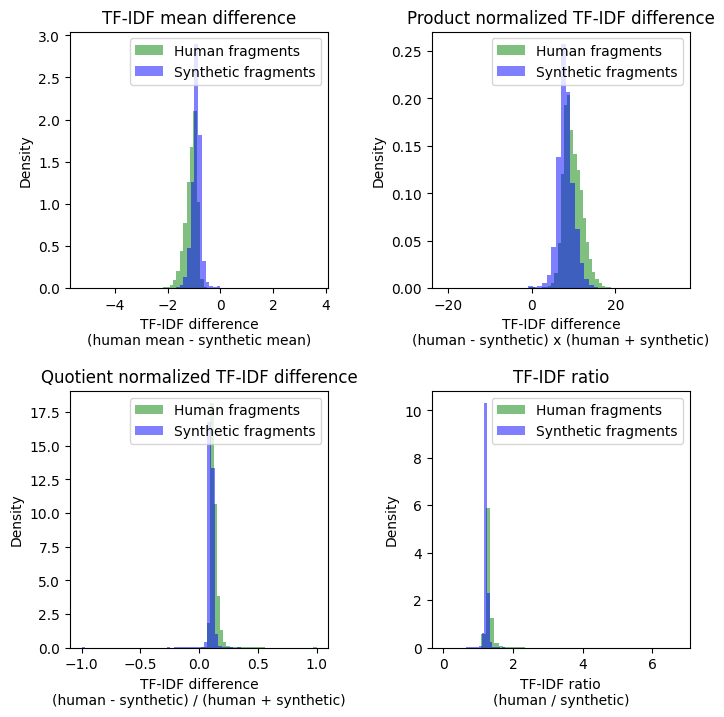

In [30]:
fig, axs = plt.subplots(
    2,
    2,
    figsize = (8, 8),
    gridspec_kw = {'wspace':0.4, 'hspace':0.4}
)

axs[0,0].set_title('TF-IDF mean difference')
axs[0,0].hist(human_dmean_tfidf, density = True, bins = 50, facecolor = 'green', label = 'Human fragments', alpha = 0.5)
axs[0,0].hist(synthetic_dmean_tfidf, density = True, bins = 50, facecolor = 'blue', label = 'Synthetic fragments', alpha = 0.5)
axs[0,0].set_xlabel('TF-IDF difference\n(human mean - synthetic mean)')
axs[0,0].set_ylabel('Density')
axs[0,0].legend(loc = 'upper right')

axs[0,1].set_title('Product normalized TF-IDF difference')
axs[0,1].hist(product_normalized_human_dmean_tfidf, density = True, bins = 50, facecolor = 'green', label = 'Human fragments', alpha = 0.5)
axs[0,1].hist(product_normalized_synthetic_dmean_tfidf, density = True, bins = 50, facecolor = 'blue', label = 'Synthetic fragments', alpha = 0.5)
axs[0,1].set_xlabel('TF-IDF difference\n(human - synthetic) x (human + synthetic)')
axs[0,1].set_ylabel('Density')
axs[0,1].legend(loc = 'upper right')

axs[1,0].set_title('Quotient normalized TF-IDF difference')
axs[1,0].hist(quotient_normalized_human_dmean_tfidf, density = True, bins = 50, facecolor = 'green', label = 'Human fragments', alpha = 0.5)
axs[1,0].hist(quotient_normalized_synthetic_dmean_tfidf, density = True, bins = 50, facecolor = 'blue', label = 'Synthetic fragments', alpha = 0.5)
axs[1,0].set_xlabel('TF-IDF difference\n(human - synthetic) / (human + synthetic)')
axs[1,0].set_ylabel('Density')
axs[1,0].legend(loc = 'upper right')

axs[1,1].set_title('TF-IDF ratio')
axs[1,1].hist(human_tfidf_mean_ratio, density = True, bins = 50, facecolor = 'green', label = 'Human fragments', alpha = 0.5)
axs[1,1].hist(synthetic_tfidf_mean_ratio, density = True, bins = 50, facecolor = 'blue', label = 'Synthetic fragments', alpha = 0.5)
axs[1,1].set_xlabel('TF-IDF ratio\n(human / synthetic)')
axs[1,1].set_ylabel('Density')
axs[1,1].legend(loc = 'upper right')

plt.show()

OK, now we are getting somewhere... I think the quotient normalized version looks like the best separation, but we can try them all if need be.

In [31]:
import numpy as np
from scipy.stats import fit, gamma, norm, exponnorm, laplace, gaussian_kde

In [32]:
# Set up bins for the combined dataset
product_normalized_dtfidfs = []
product_normalized_dtfidfs.extend(product_normalized_human_dmean_tfidf)
product_normalized_dtfidfs.extend(product_normalized_synthetic_dmean_tfidf)

counts, bins = np.histogram(product_normalized_dtfidfs, bins = 100, density = True)

# Get bin centers
bin_centers = (bins[:-1] + bins[1:]) / 2

# Calculate histograms for the human and synthetic data
human_density, human_bins = np.histogram(product_normalized_human_dmean_tfidf, bins = bins, density = True)
synthetic_density, synthetic_bins = np.histogram(product_normalized_synthetic_dmean_tfidf, bins = bins, density = True)

In [33]:
# Gaussian distribution
bounds = [[-10.0,10.0],[-10.0,10.0]]

human_norm = fit(norm, product_normalized_human_dmean_tfidf, bounds = bounds)
human_norm_fit = norm(human_norm.params.loc, human_norm.params.scale).pdf(bin_centers)

synthetic_norm = fit(norm, product_normalized_synthetic_dmean_tfidf, bounds = bounds)
synthetic_norm_fit = norm(synthetic_norm.params.loc, synthetic_norm.params.scale).pdf(bin_centers)

print(f'Human loc: {human_norm.params.loc}')
print(f'Human scale: {human_norm.params.scale}')

Human loc: 9.8392323955415
Human scale: 2.2850801421487885


/mnt/arkk/llm_detector/.venv/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1636: RuntimeWarning: overflow encountered in divide
  x = asarray((x-loc) / scale)


In [34]:
# Exponential Gaussian
bounds = [[-10.0,10.0],[-10.0,10.0],[-10.0,10.0]]

human_exponnorm = fit(exponnorm, product_normalized_human_dmean_tfidf, bounds = bounds)
human_exponnorm_fit = exponnorm(human_exponnorm.params.K, human_exponnorm.params.loc, human_exponnorm.params.scale).pdf(bin_centers)

synthetic_exponnorm = fit(exponnorm, product_normalized_synthetic_dmean_tfidf, bounds = bounds)
synthetic_exponnorm_fit = exponnorm(synthetic_exponnorm.params.K, synthetic_exponnorm.params.loc, synthetic_exponnorm.params.scale).pdf(bin_centers)

print(f'Human K: {human_exponnorm.params.K}')
print(f'Human loc: {human_exponnorm.params.loc}')
print(f'Human scale: {human_exponnorm.params.scale}')

Human K: 0.9001324475783764
Human loc: 8.305191151033293
Human scale: 1.6968331487605932


In [35]:
# Gamma distribution
bounds = [[-100.0,100.0],[-100.0,100.0],[-10.0,10.0]]

human_gamma = fit(gamma, product_normalized_human_dmean_tfidf, bounds = bounds)
human_gamma_fit = gamma(human_gamma.params.a, human_gamma.params.loc, human_gamma.params.scale).pdf(bin_centers)

synthetic_gamma = fit(gamma, product_normalized_synthetic_dmean_tfidf, bounds = bounds)
synthetic_gamma_fit = gamma(synthetic_gamma.params.a, synthetic_gamma.params.loc, synthetic_gamma.params.scale).pdf(bin_centers)

print(f'Human a: {human_gamma.params.a}')
print(f'Human loc: {human_gamma.params.loc}')
print(f'Human scale: {human_gamma.params.scale}')

Human a: 43.61354535497117
Human loc: -5.310725355523771
Human scale: 0.34721518319655137


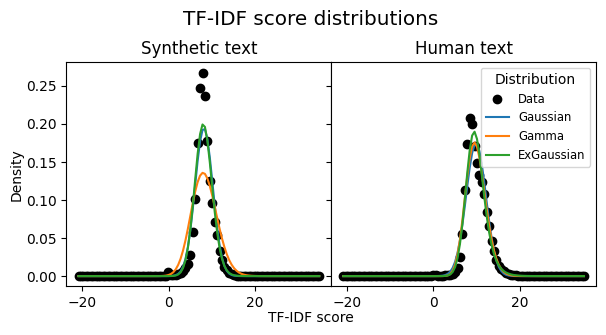

In [36]:
fig, axs = plt.subplots(
    1,
    2,
    figsize = (6, 3),
    sharex = 'col',
    sharey = 'row',
    tight_layout = True,
    gridspec_kw = {'wspace':0, 'hspace':0}
)

axs[0].set_title('Synthetic text')
axs[0].scatter(bin_centers, synthetic_density, color = 'black', label = 'Data')
axs[0].plot(bin_centers, synthetic_norm_fit, label = 'Gaussian')
axs[0].plot(bin_centers, synthetic_gamma_fit, label = 'Gamma')
axs[0].plot(bin_centers, synthetic_exponnorm_fit, label = 'ExGaussian')

axs[1].set_title('Human text')
axs[1].scatter(bin_centers, human_density, color = 'black', label = 'Data')
axs[1].plot(bin_centers, human_norm_fit, label = 'Gaussian')
axs[1].plot(bin_centers, human_gamma_fit, label = 'Gamma')
axs[1].plot(bin_centers, human_exponnorm_fit, label = 'ExGaussian')

axs[1].legend(
    title = 'Distribution',
    loc = 'upper right',
    fontsize = 'small'
)

# Set figure title
fig.text(0.5, 1, 'TF-IDF score distributions', ha = 'center', fontsize = 'x-large')

# Set single label for shared x
fig.text(0.5, 0.01, 'TF-IDF score', ha = 'center')

# Set single label for shared y
fig.text(0.01, 0.5, 'Density', va = 'center', ha = 'center', rotation = 90)

plt.show()

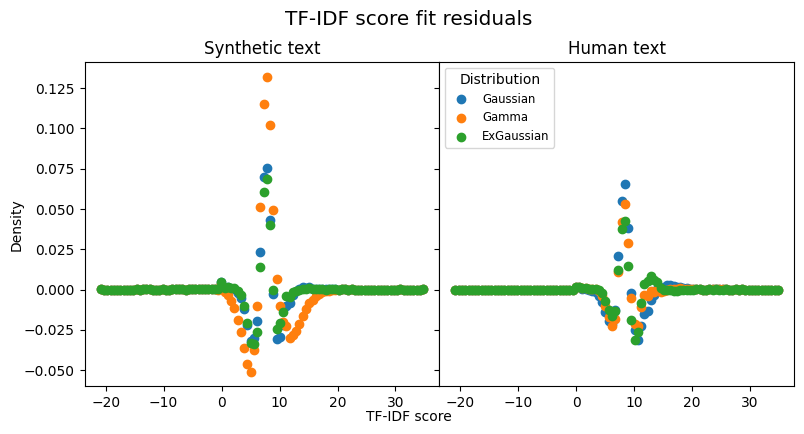

In [37]:
fig, axs = plt.subplots(
    1,
    2,
    figsize = (8, 4),
    sharex = 'col',
    sharey = 'row',
    tight_layout = True,
    gridspec_kw = {'wspace':0, 'hspace':0}
)

axs[0].set_title('Synthetic text')
axs[0].scatter(bin_centers, (synthetic_density - synthetic_norm_fit), label = 'Gaussian')
axs[0].scatter(bin_centers, (synthetic_density - synthetic_gamma_fit), label = 'Gamma')
axs[0].scatter(bin_centers, (synthetic_density - synthetic_exponnorm_fit), label = 'ExGaussian')

axs[1].set_title('Human text')
axs[1].scatter(bin_centers, (human_density - human_norm_fit), label = 'Gaussian')
axs[1].scatter(bin_centers, (human_density - human_gamma_fit), label = 'Gamma')
axs[1].scatter(bin_centers, (human_density - human_exponnorm_fit), label = 'ExGaussian')

axs[1].legend(
    title = 'Distribution',
    loc = 'upper left',
    fontsize = 'small'
)

# Set figure title
fig.text(0.5, 1, 'TF-IDF score fit residuals', ha = 'center', fontsize = 'x-large')

# Set single label for shared x
fig.text(0.5, 0.01, 'TF-IDF score', ha = 'center')

# Set single label for shared y
fig.text(0.01, 0.5, 'Density', va = 'center', ha = 'center', rotation = 90)

plt.show()

OK, looks like we probably should go with the exponential Gaussian again. Or maybe try a kernel density estimate. Let's just see how the KL divergence looks.

In [38]:
from math import log2

def kl_divergence(p, q):
    '''Takes two lists, calculates KD divergence'''
    return [p[i] * log2(p[i]/q[i]) for i in range(len(p))]

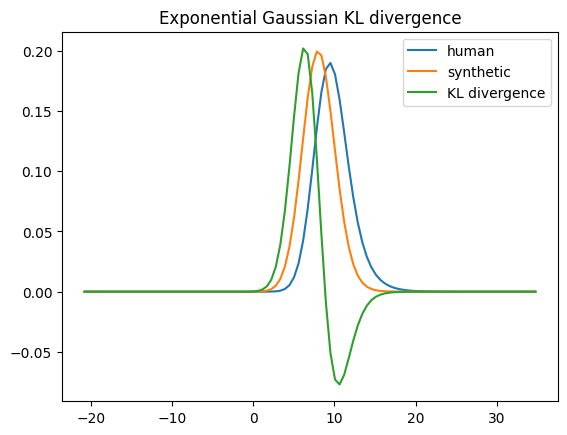

In [39]:
plt.title('Exponential Gaussian KL divergence')
plt.plot(bin_centers, human_exponnorm_fit, label = 'human')
plt.plot(bin_centers, synthetic_exponnorm_fit, label = 'synthetic')
plt.plot(bin_centers, kl_divergence(synthetic_exponnorm_fit, human_exponnorm_fit), label = 'KL divergence')
plt.legend(loc = 'upper right')
plt.show()

Sweet - I think we got it! Now, similarly to how we handled perplexity ratio score, we need a probability density function for the Kullback-Leibler divergence distribution. To do that - we need a kernel density estimate, and to do that - we need to reconstruct KL scores that would give the observed distribution.

In [40]:
# Get a kernel density estimate of the KL divergence so we can use the
# associated probability density function to convert perplexity ratio scores
# into KL scores

tfidf_scores = product_normalized_human_dmean_tfidf + product_normalized_synthetic_dmean_tfidf

# Get a list of points covering the range of score values
x = np.arange(min(tfidf_scores) - 10, max(tfidf_scores) + 10, 0.1).tolist()
print(f'Will calculate {len(x)} fitted values')

# Do the exponential gaussian fits and get values for f(x)
bounds = [[-10.0,10.0],[-10.0,10.0],[-10.0,10.0]]

human_exponnorm = fit(exponnorm, product_normalized_human_dmean_tfidf, bounds = bounds)
human_exponnorm_fit = exponnorm(human_exponnorm.params.K, human_exponnorm.params.loc, human_exponnorm.params.scale).pdf(x)

synthetic_exponnorm = fit(exponnorm, product_normalized_synthetic_dmean_tfidf, bounds = bounds)
synthetic_exponnorm_fit = exponnorm(synthetic_exponnorm.params.K, synthetic_exponnorm.params.loc, synthetic_exponnorm.params.scale).pdf(x)

# Calculate the KL divergence of the fitted values
kl = kl_divergence(synthetic_exponnorm_fit, human_exponnorm_fit)

print(f'Have {len(kl)} KL divergence values')

Will calculate 762 fitted values
Have 762 KL divergence values


Min KL count value 0
Max KL count value: 27


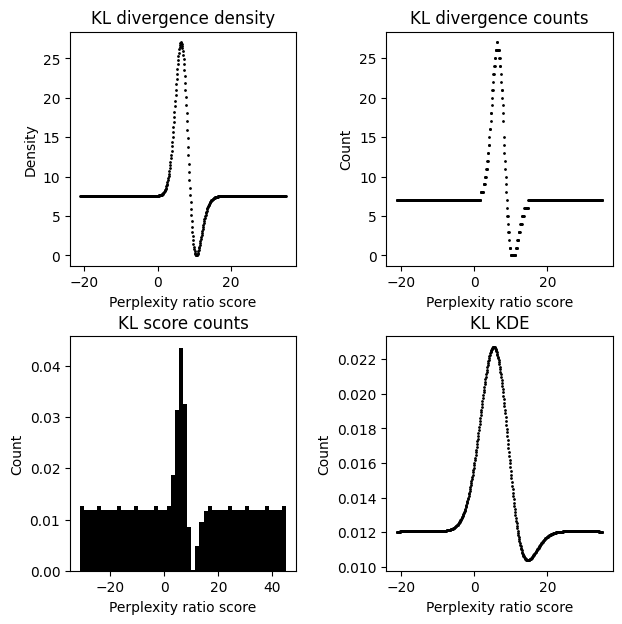

In [41]:
# Convert the kl 'density' values into integer 'count' values
kl = kl_divergence(synthetic_exponnorm_fit, human_exponnorm_fit)
kl = kl + abs(min(kl))
kl = kl * 100
kl_counts = [int(density) for density in kl]

print(f'Min KL count value {min(kl_counts)}')
print(f'Max KL count value: {max(kl_counts)}')

# Now, construct a list where each value of x appears a number of times
# equal to it's kl 'count'
kl_scores = []

for i in range(len(kl_counts)):
    kl_scores.extend([x[i]] * kl_counts[i])

# Finally, run a KDE on the reconstructed KL scores
kl_kde = gaussian_kde(kl_scores)

# And use it's PDF to get density for x after re-clipping x to the
# range of the original data
clipped_x = []
clipped_kl = []
clipped_kl_counts = []

for i, j in enumerate(x):
    if j > min(tfidf_scores) and j < max(tfidf_scores):
        clipped_x.append(j)
        clipped_kl.append(kl[i])
        clipped_kl_counts.append(kl_counts[i])

clipped_kl_kde_values = kl_kde.pdf(clipped_x)

fig, axs = plt.subplots(
    2,
    2,
    figsize = (7, 7),
    gridspec_kw = {'wspace':0.4, 'hspace':0.3}
)

axs[0,0].set_title('KL divergence density')
axs[0,0].scatter(clipped_x, clipped_kl, color='black', s = 1)
axs[0,0].set_xlabel('Perplexity ratio score')
axs[0,0].set_ylabel('Density')

axs[0,1].set_title('KL divergence counts')
axs[0,1].scatter(clipped_x, clipped_kl_counts, color='black', s = 1)
axs[0,1].set_xlabel('Perplexity ratio score')
axs[0,1].set_ylabel('Count')

axs[1,0].set_title('KL score counts')
axs[1,0].hist(kl_scores, bins=50, color='black', density = True)
axs[1,0].set_xlabel('Perplexity ratio score')
axs[1,0].set_ylabel('Count')

axs[1,1].set_title('KL KDE')
axs[1,1].scatter(clipped_x, clipped_kl_kde_values, color='black', s = 1)
axs[1,1].set_xlabel('Perplexity ratio score')
axs[1,1].set_ylabel('Count')

plt.show()

OK, cool. Looks good. Now we need to TF-IDF score the fragments from the Hans 2024 corpus, and run the scores though the KL KDE's PDF and add the result to the dataframe.

In [42]:
data_df.head()

,Fragment length (tokens),Dataset,Source,String,Perplexity,Cross-perplexity,Perplexity ratio score,Perplexity ratio Kullback-Leibler score
0,229,cc_news-falcon7,human,H. B. Fuller Company (NYSE:FUL) VP Traci L. Je...,0.971085,1.146746,0.846818,1.498175
1,267,cc_news-falcon7,human,specialty chemicals company reported $0.65 ear...,1.185710,1.238428,0.957431,0.189686
2,290,cc_news-falcon7,human,reposted in violation of US and international ...,1.212603,1.270731,0.954256,0.198995
3,156,cc_news-falcon7,human,one has issued a buy rating to the company. Th...,1.285289,1.332959,0.964237,0.174337
4,231,cc_news-falcon7,human,specialty chemicals company’s stock valued at ...,1.272878,1.475141,0.862886,1.220695


In [43]:
# Holders for new features
tfidf_scores = []
human_tfidf = []
synthetic_tfidf = []

# Loop on dataframe rows
for index, row in data_df.iterrows():
    
    human_tfidf_sum = 0
    synthetic_tfidf_sum = 0

    # Get the text from this row
    text = row['String']

    # Clean the text
    text = clean_text(text)

    # Split the text into words
    words = text.split(' ')

    # Score the words using the human and synthetic luts
    for word in words:

        if word in tfidf_luts['human'].keys():
            human_tfidf_sum += tfidf_luts['human'][word]

        if word in tfidf_luts['synthetic'].keys():
            synthetic_tfidf_sum += tfidf_luts['synthetic'][word]

    # Get the means
    human_tfidf_mean = human_tfidf_sum / len(words)
    synthetic_tfidf_mean = synthetic_tfidf_sum / len(words)
    dmean_tfidf = human_tfidf_mean - synthetic_tfidf_mean
    product_normalized_dmean_tfidf = dmean_tfidf * (human_tfidf_mean + synthetic_tfidf_mean)

    human_tfidf.append(human_tfidf_mean)
    synthetic_tfidf.append(synthetic_tfidf_mean)
    tfidf_scores.append(product_normalized_dmean_tfidf)

In [44]:
data_df['Human TF-IDF'] = human_tfidf
data_df['Synthetic TF-IDF'] = synthetic_tfidf
data_df['TF-IDF score'] = tfidf_scores

In [45]:
kl_scores = kl_kde.pdf(tfidf_scores)
data_df['TF-IDF Kullback-Leibler score'] = kl_scores

# Out of range data produced strange (or null) values, so clip any high outliers and replace the KL score with NAN
data_df['TF-IDF Kullback-Leibler score'][data_df['TF-IDF score'] > 25.0] = np.nan

data_df.head()
print()
data_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 119818 entries, 0 to 119817
Data columns (total 12 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   Fragment length (tokens)                 119818 non-null  int64  
 1   Dataset                                  119818 non-null  object 
 2   Source                                   119818 non-null  object 
 3   String                                   119818 non-null  object 
 4   Perplexity                               119818 non-null  float64
 5   Cross-perplexity                         119818 non-null  float64
 6   Perplexity ratio score                   119818 non-null  float64
 7   Perplexity ratio Kullback-Leibler score  119730 non-null  float64
 8   Human TF-IDF                             119818 non-null  float64
 9   Synthetic TF-IDF                         119818 non-null  float64
 10  TF-IDF score                        

/tmp/ipykernel_389858/2723384763.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['TF-IDF Kullback-Leibler score'][data_df['TF-IDF score'] > 25.0] = np.nan


Re-plot just to be sure we got the result we expected:

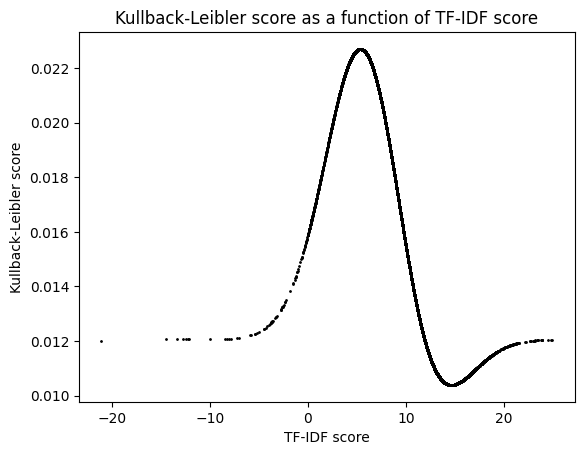

In [46]:
plt.title('Kullback-Leibler score as a function of TF-IDF score')
plt.scatter(data_df['TF-IDF score'], data_df['TF-IDF Kullback-Leibler score'], color='black', s = 1)
plt.xlabel('TF-IDF score')
plt.ylabel('Kullback-Leibler score')
plt.show()

Nailed it! Save for the next step.

In [47]:
# Save as JSON for later use
output_file = config.COMBINED_SCORED_HANS_DATA_PR_TFIDF

with open(output_file, 'w') as file:
    file.write(data_df.to_json())